In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import xgboost as xgb 
import warnings
import pickle
import requests
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')


def save_csv(df, name):
    df.to_csv("../Data/" + name)

              
def read_csv(name):
    return pd.read_csv("../Data/" + name)


def change_time(d):
    for i in range(len(d)):
        a, b = d[i].split(":")
        b, c = b.split(".")
        d[i] = int(a) * 60 + int(b) + int(c) * 0.1
    return d


def topn(d, n):
    d2 = list()
    for i in range(len(d)):
        if int(d[i]) <= n:
            d2.append(1)
        else:
            d2.append(0)
    return d2

def change_w(d):
    d2 = list()
    d3 = list()
    for i in range(len(d)):
        if not str(d[i]).isdigit():
            a, b = d[i].split("(")
            b, c = b.split(")")
        else:
            a = d[i]
            b = 0
        d2.append(int(a))
        d3.append(int(b))
    return d2, d3

def df_half(df, n, s):
    d = df.copy()
    for i in range(len(df)):
        if d.loc[i, s] != 1 and n > 0:
            d = d.drop(i)
            n -= 1
    return d

def point(df, df2):
    d = np.sqrt(1/df2.着順 ** 2 * 100)
    d[df2["着順"] <= 8] += 1.0/df2.着順*10
    return d
#     return np.sqrt(np.sqrt(df.単勝)/df2.着順 ** 2 * 100)[df2["着順"] <= 3]
#     return [int(3.0/i*10) if i < 6 else 0 for i in df["着順"]]

def favorite(df):
    d = np.sqrt(df.単勝 / df.人気 ** 5 * 100)
    return np.round(d, 5)

def seirei(df):
    d2 = list()
    d3 = list()
    for i in range(len(df)):
        a, b = df.性齢[i][0], df.性齢[i][1]
        d2.append(str(a))
        d3.append(int(b))
    return d2, d3

F:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = read_csv("results_2021")
def cre_df(df, f=False, le_sei=None, le_we=None, le_ra=None, le_ra2=None, le_gr=None, le_rp=None, le_tyo=None):
    df = df.rename(columns={'Unnamed: 0': 'id'})
    df = df.reindex(columns=['id', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手',
           '単勝', '人気', '馬体重', '調教師', 'race_place', 'course_len', 
           'weather', 'race_type', 'race_type2', 'ground_state', 'date', 
             'horse_id', 'jockey_id', '着順', 'タイム', '着差'])
    df['着順'] = pd.to_numeric(df['着順'], errors="coerce")
    df = df.dropna(subset=['着順']).reset_index(drop=True)
    df = df.sort_values(["id", "枠番"], ascending=[True, True]).reset_index(drop=True)
    df['top3'] = topn(df['着順'], 3)
    df['top5'] = topn(df['着順'], 5)
    df2 = df[['id', '着順', 'タイム']]
    df = df.drop(['馬名', '騎手'], axis=1)
    df = df.drop(['着差', '馬番', '着順', 'タイム', 'top3', 'top5'], axis=1)
    df['性'], df['齢']  = seirei(df)
    if f:
        le_sei = LabelEncoder()
        le_we = LabelEncoder()
        le_ra = LabelEncoder()
        le_ra2 = LabelEncoder()
        le_gr = LabelEncoder()
        le_rp = LabelEncoder()
        le_tyo = LabelEncoder()
        df['性'] = le_sei.fit_transform(df['性'].values)
        df['weather'] = le_we.fit_transform(df['weather'].values)
        df['race_type'] = le_ra.fit_transform(df['race_type'].values)
        df['race_type2'] = le_ra2.fit_transform(df['race_type2'].values)
        df['ground_state'] = le_gr.fit_transform(df['ground_state'].values)
        df['race_place'] = le_rp.fit_transform(df['race_place'].values)
#         df['調教師'] = le_tyo.fit_transform(df['調教師'].values)
    else:
        df['性'] = le_sei.transform(df['性'].values)
        df['weather'] = le_we.transform(df['weather'].values)
        df['race_type'] = le_ra.transform(df['race_type'].values)
        df['race_type2'] = le_ra2.transform(df['race_type2'].values)
        df['ground_state'] = le_gr.transform(df['ground_state'].values)
        df['race_place'] = le_rp.transform(df['race_place'].values)
#         df['調教師'] = le_tyo.transform(df['調教師'].values)
    # le_ho = LabelEncoder()
    # df['horse_id'] = le_ho.fit_transform(df['horse_id'].values)
    # le_jo = LabelEncoder()
    # df['jockey_id'] = le_jo.fit_transform(df['jockey_id'].values)
#     le_co = LabelEncoder()
#     df['course_len'] = le_co.fit_transform(df['course_len'].values)
    df['horse_id'] = df['horse_id'].astype("int64")
    df['jockey_id'] = df['jockey_id'].astype("int64")
    df['course_len'] = df['course_len'].astype("int64")
#     df['馬体重'], df['馬体重差'] = change_w(df['馬体重'])
#     df['全体重'] = df.馬体重 + df.斤量
    df = df.drop(['馬体重'], axis=1)
    # df['馬体重差'] = preprocessing.minmax_scale(df['馬体重差'])
    df['人気'] = df['人気'].astype("int64")
    df['枠番'] = df['枠番'].astype("int64")
    df['単勝'] = df['単勝'].astype("float64")
    df2['着順'] = df2['着順'].astype("int64")
    df2['タイム'] = np.round(change_time(df2['タイム']).astype("float64"), 1)
    df['fav'] = favorite(df)
    df["date"] = pd.to_datetime(df['date'], format='%Y年%m月%d日')
#     df = df.reindex(columns=['id', "date", '枠番', '性', '齢', '斤量', '馬体重', '馬体重差', '全体重',
#     '単勝', '人気', 'fav','調教師', 'horse_id',
#     'jockey_id', 'race_place', 'course_len',
#     'weather', 'race_type', 'race_type2', 'ground_state'])
    df = df.reindex(columns=['horse_id', 'jockey_id', 'id', "date", '枠番', '性', '齢', '斤量',
    '単勝', '人気', 'fav','調教師','race_place', 'course_len',
    'weather', 'race_type', 'race_type2', 'ground_state'])
    df = df.drop(['調教師', 'jockey_id', '単勝', '人気', 'fav'], axis=1)
    if not f:
        return df, df2
    else:
        return df, df2, le_sei, le_we, le_ra, le_ra2, le_gr, le_rp, le_tyo
    
df, df2, le_sei, le_we, le_ra, le_ra2, le_gr, le_rp, le_tyo = cre_df(df, True)
que = list(df.groupby("id").size())
df = df.drop(['id'], axis=1)
# df = read_csv("df_2021").rename(columns={'Unnamed: 0': 'id'}).drop('id', axis=1)
df

,horse_id,date,枠番,性,齢,斤量,race_place,course_len,weather,race_type,race_type2,ground_state
0,2018100570,2021-06-12,1,1,3,54.0,5,1200,0,1,0,2
1,2018104780,2021-06-12,1,2,3,56.0,5,1200,0,1,0,2
2,2018101518,2021-06-12,2,1,3,52.0,5,1200,0,1,0,2
3,2018101447,2021-06-12,2,2,3,56.0,5,1200,0,1,0,2
4,2018105258,2021-06-12,3,2,3,56.0,5,1200,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,3,2600,2,1,0,2
47472,2017100368,2021-09-05,7,2,4,57.0,3,2600,2,1,0,2
47473,2018104097,2021-09-05,7,2,3,53.0,3,2600,2,1,0,2
47474,2017102850,2021-09-05,8,2,4,57.0,3,2600,2,1,0,2


In [3]:
# hor = read_csv("horse_2021")
# hor = hor.rename(columns={'Unnamed: 0': 'id'})
# hor = hor.sort_values(["id", "日付"], ascending=[True, True]).reset_index(drop=True)
# hor = hor.drop(['映像', 'ﾀｲﾑ指数', '厩舎ｺﾒﾝﾄ', '備考', "R", "通過", "ペース",
#               "勝ち馬(2着馬)", "馬場指数", "レース名", "馬番", "賞金"], axis=1)
# hor = hor.dropna(subset=['天気', "枠番", "オッズ", "人気", "タイム", "上り", "着差"]).reset_index(drop=True)
# hor["日付"] = pd.to_datetime(hor['日付'], format='%Y/%m/%d')
# hor
# l1, l2, l3, l4, l5 = [], [], [], [], []
# for i in range(len(df)):
#     l = hor.loc[hor[(df.loc[i, "date"] == hor["日付"]) & 
#               (df.loc[i, "horse_id"] == hor["id"])].index[0] - 1, ["オッズ", "人気", "着順", "タイム", "距離"]]
#     l1.append(l[0])
#     l2.append(l[1])
#     l3.append(l[2])
# #     l4.append(l[3])
# #     l5.append(l[4][1:])

# df["前オッズ"] = l1
# df["前人気"] = l2
# df["前着順"] = l3
# # df["前距離"] = l5
# # df["前タイム"] = change_time(l4)
# # df["前距離"] = df["前距離"].astype("int64")
# # df["前スピード"] = df["前距離"] / df["前タイム"]
# # df1 = df.copy()
# df

In [4]:
# df2['t'] = point(df, df2).astype("int64")
# df2['スピード'] = df.course_len / df2.タイム
# # df2 = read_csv("df2_2021").rename(columns={'Unnamed: 0': 'id2'}).drop('id2', axis=1)
# df2

In [5]:
# save_csv(df, "df_2021_pred3")
# save_csv(df2, "df2_2021_pred3")
df = read_csv("df_2021_pred3").drop('Unnamed: 0', axis=1)
df2 = read_csv("df2_2021_pred3").drop('Unnamed: 0', axis=1)
df

,horse_id,date,枠番,性,齢,斤量,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順
0,2018100570,2021-06-12,1,1,3,54.0,5,1200,0,1,0,2,2.7,1.0,11.0
1,2018104780,2021-06-12,1,2,3,56.0,5,1200,0,1,0,2,5.6,3.0,2.0
2,2018101518,2021-06-12,2,1,3,52.0,5,1200,0,1,0,2,372.5,15.0,16.0
3,2018101447,2021-06-12,2,2,3,56.0,5,1200,0,1,0,2,42.2,12.0,13.0
4,2018105258,2021-06-12,3,2,3,56.0,5,1200,0,1,0,2,3.8,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,3,2600,2,1,0,2,27.5,6.0,7.0
47472,2017100368,2021-09-05,7,2,4,57.0,3,2600,2,1,0,2,13.1,5.0,6.0
47473,2018104097,2021-09-05,7,2,3,53.0,3,2600,2,1,0,2,47.7,9.0,9.0
47474,2017102850,2021-09-05,8,2,4,57.0,3,2600,2,1,0,2,5.1,3.0,4.0


In [6]:
df2

,id,着順,タイム,単勝,人気,t,スピード
0,202101010101,6,69.0,3.7,1.0,3,17.391304
1,202101010101,15,70.2,10.4,6.0,0,17.094017
2,202101010101,10,69.6,275.3,16.0,1,17.241379
3,202101010101,12,69.9,57.7,11.0,0,17.167382
4,202101010101,2,68.8,3.9,2.0,10,17.441860
...,...,...,...,...,...,...,...
47471,202110040812,11,162.6,82.5,11.0,0,15.990160
47472,202110040812,8,162.2,43.7,8.0,2,16.029593
47473,202110040812,9,162.2,46.5,9.0,1,16.029593
47474,202110040812,1,161.0,3.6,2.0,20,16.149068


In [7]:
x = df.drop(["date"], axis=1).astype("float32")
y = df2['スピード']
x_train = x.iloc[:sum(que[:int(len(que) * 0.6)])]
x_valid = x.iloc[sum(que[:int(len(que) * 0.6)]):sum(que[:int(len(que) * 0.7)])]
x_test = x.iloc[sum(que[:int(len(que) * 0.7)]):]
y_train = y.iloc[:sum(que[:int(len(que) * 0.6)])]
y_valid = y.iloc[sum(que[:int(len(que) * 0.6)]):sum(que[:int(len(que) * 0.7)])]
y_test = y.iloc[sum(que[:int(len(que) * 0.7)]):]
train_query = que[:int(len(que) * 0.6)]
val_query = que[int(len(que) * 0.6):int(len(que) * 0.7)]
test_query = que[int(len(que) * 0.7):]
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
params = {
        'task': 'train',            
        'boosting_type': 'gbdt',   
        'objective': 'regression',  
        'metric': 'rmse',      
        'learning_rate': 0.001,
        'random_state': 0,
          }
model_s = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=lgb_valid, 
                  valid_names=['train','valid'], early_stopping_rounds=100, verbose_eval=-1)
importance = pd.DataFrame(model_s.feature_importance(), index=df.drop(["date"], axis=1).columns, columns=['importance'])
display(importance)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 29155, number of used features: 14
[LightGBM] [Info] Start training from score 16.245835
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2779]	train's rmse: 0.282682


,importance
horse_id,12492
枠番,53
性,834
齢,2267
斤量,387
race_place,7432
course_len,20017
weather,2070
race_type,7946
race_type2,2572


In [8]:
# model_s = pickle.load(open('../Data/model/lightgbm/model_s.pkl', 'rb'))

In [9]:
df["pred_s"] = model_s.predict(x, num_iteration=model_s.best_iteration)
df

,horse_id,date,枠番,性,齢,斤量,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s
0,2018100570,2021-06-12,1,1,3,54.0,5,1200,0,1,0,2,2.7,1.0,11.0,17.102225
1,2018104780,2021-06-12,1,2,3,56.0,5,1200,0,1,0,2,5.6,3.0,2.0,17.115887
2,2018101518,2021-06-12,2,1,3,52.0,5,1200,0,1,0,2,372.5,15.0,16.0,16.992584
3,2018101447,2021-06-12,2,2,3,56.0,5,1200,0,1,0,2,42.2,12.0,13.0,17.046042
4,2018105258,2021-06-12,3,2,3,56.0,5,1200,0,1,0,2,3.8,2.0,2.0,17.115887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,3,2600,2,1,0,2,27.5,6.0,7.0,15.991395
47472,2017100368,2021-09-05,7,2,4,57.0,3,2600,2,1,0,2,13.1,5.0,6.0,16.014133
47473,2018104097,2021-09-05,7,2,3,53.0,3,2600,2,1,0,2,47.7,9.0,9.0,15.965798
47474,2017102850,2021-09-05,8,2,4,57.0,3,2600,2,1,0,2,5.1,3.0,4.0,16.013998


In [10]:
x = df.drop(["date"], axis=1).astype("float32")
y = df2['タイム']
x_train = x.iloc[:sum(que[:int(len(que) * 0.6)])]
x_valid = x.iloc[sum(que[:int(len(que) * 0.6)]):sum(que[:int(len(que) * 0.7)])]
x_test = x.iloc[sum(que[:int(len(que) * 0.7)]):]
y_train = y.iloc[:sum(que[:int(len(que) * 0.6)])]
y_valid = y.iloc[sum(que[:int(len(que) * 0.6)]):sum(que[:int(len(que) * 0.7)])]
y_test = y.iloc[sum(que[:int(len(que) * 0.7)]):]
train_query = que[:int(len(que) * 0.6)]
val_query = que[int(len(que) * 0.6):int(len(que) * 0.7)]
test_query = que[int(len(que) * 0.7):]
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
# lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)
params = {
        'task': 'train',            
        'boosting_type': 'gbdt',   
        'objective': 'regression',  
        'metric': 'rmse',      
        'learning_rate': 0.001,
        'random_state': 0,
#         'device':'gpu',
#         '-DUSE_GPU' : 1,
    
          }
model_t = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=lgb_valid, 
                  valid_names=['train','valid'], early_stopping_rounds=100, verbose_eval=-1)
importance = pd.DataFrame(model_t.feature_importance(), index=df.drop(["date"], axis=1).columns, columns=['importance'])
display(importance)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 29155, number of used features: 15
[LightGBM] [Info] Start training from score 102.229892
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3710]	train's rmse: 2.09993


,importance
horse_id,2093
枠番,0
性,310
齢,0
斤量,1228
race_place,2076
course_len,51165
weather,2105
race_type,590
race_type2,759


In [11]:
# model_t = pickle.load(open('../Data/model/lightgbm/model_t.pkl', 'rb'))

In [12]:
df["pred_t"] = model_t.predict(x, num_iteration=model_t.best_iteration)
# df["pred_s"] = df["course_len"] / df["pred_t"]
df

,horse_id,date,枠番,性,齢,斤量,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t
0,2018100570,2021-06-12,1,1,3,54.0,5,1200,0,1,0,2,2.7,1.0,11.0,17.102225,70.866227
1,2018104780,2021-06-12,1,2,3,56.0,5,1200,0,1,0,2,5.6,3.0,2.0,17.115887,70.557967
2,2018101518,2021-06-12,2,1,3,52.0,5,1200,0,1,0,2,372.5,15.0,16.0,16.992584,71.161468
3,2018101447,2021-06-12,2,2,3,56.0,5,1200,0,1,0,2,42.2,12.0,13.0,17.046042,70.871659
4,2018105258,2021-06-12,3,2,3,56.0,5,1200,0,1,0,2,3.8,2.0,2.0,17.115887,70.557967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,3,2600,2,1,0,2,27.5,6.0,7.0,15.991395,161.396077
47472,2017100368,2021-09-05,7,2,4,57.0,3,2600,2,1,0,2,13.1,5.0,6.0,16.014133,161.250721
47473,2018104097,2021-09-05,7,2,3,53.0,3,2600,2,1,0,2,47.7,9.0,9.0,15.965798,162.330606
47474,2017102850,2021-09-05,8,2,4,57.0,3,2600,2,1,0,2,5.1,3.0,4.0,16.013998,161.250721


In [13]:
x = df.drop(["date"], axis=1).astype("float32")
y = pd.DataFrame(topn(df2['着順'], 5))
x_train = x.iloc[:sum(que[:int(len(que) * 0.8)])]
x_valid = x.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
x_test = x.iloc[sum(que[:int(len(que) * 0.9)]):]
y_train = y.iloc[:sum(que[:int(len(que) * 0.8)])]
y_valid = y.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
y_test = y.iloc[sum(que[:int(len(que) * 0.9)]):]
w = pd.DataFrame(index=x_train.index)
w = (y_train == 1)
w[0] = w[0] * 1 + 1
lgb_train = lgb.Dataset(x_train, y_train, weight=w[0])
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',#'auc'
    'learning_rate': 0.001,
    'random_state': 0,
}
model_5 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=lgb_valid, 
                  valid_names=['train','valid'], early_stopping_rounds=100, verbose_eval=-1)
importance = pd.DataFrame(model_5.feature_importance(), index=df.drop(["date"], axis=1).columns, columns=['importance'])
display(importance)

[LightGBM] [Info] Number of positive: 13829, number of negative: 24489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 38318, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530385 -> initscore=0.121691
[LightGBM] [Info] Start training from score 0.121691
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2081]	train's binary_logloss: 0.663344


,importance
horse_id,11061
枠番,1305
性,1614
齢,891
斤量,4761
race_place,1330
course_len,1420
weather,107
race_type,1243
race_type2,435


In [14]:
# model_5 = pickle.load(open('../Data/model/lightgbm/model_5.pkl', 'rb'))

In [15]:
df["pred_5"] = pd.DataFrame(model_5.predict(x, num_iteration=
                     model_5.best_iteration))
# .applymap(lambda xx : 0 if xx<=0.5 else 1)
df

,horse_id,date,枠番,性,齢,斤量,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5
0,2018100570,2021-06-12,1,1,3,54.0,5,1200,0,1,0,2,2.7,1.0,11.0,17.102225,70.866227,0.598887
1,2018104780,2021-06-12,1,2,3,56.0,5,1200,0,1,0,2,5.6,3.0,2.0,17.115887,70.557967,0.734697
2,2018101518,2021-06-12,2,1,3,52.0,5,1200,0,1,0,2,372.5,15.0,16.0,16.992584,71.161468,0.187455
3,2018101447,2021-06-12,2,2,3,56.0,5,1200,0,1,0,2,42.2,12.0,13.0,17.046042,70.871659,0.381422
4,2018105258,2021-06-12,3,2,3,56.0,5,1200,0,1,0,2,3.8,2.0,2.0,17.115887,70.557967,0.740845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,3,2600,2,1,0,2,27.5,6.0,7.0,15.991395,161.396077,0.491421
47472,2017100368,2021-09-05,7,2,4,57.0,3,2600,2,1,0,2,13.1,5.0,6.0,16.014133,161.250721,0.624403
47473,2018104097,2021-09-05,7,2,3,53.0,3,2600,2,1,0,2,47.7,9.0,9.0,15.965798,162.330606,0.413490
47474,2017102850,2021-09-05,8,2,4,57.0,3,2600,2,1,0,2,5.1,3.0,4.0,16.013998,161.250721,0.725827


In [16]:
x = df.drop(["date"], axis=1).astype("float32")
y = pd.DataFrame(topn(df2['着順'], 3))
x_train = x.iloc[:sum(que[:int(len(que) * 0.8)])]
x_valid = x.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
x_test = x.iloc[sum(que[:int(len(que) * 0.9)]):]
y_train = y.iloc[:sum(que[:int(len(que) * 0.8)])]
y_valid = y.iloc[sum(que[:int(len(que) * 0.8)]):sum(que[:int(len(que) * 0.9)])]
y_test = y.iloc[sum(que[:int(len(que) * 0.9)]):]
w = pd.DataFrame(index=x_train.index)
w = (y_train == 1)
w[0] = w[0] * 3 + 1
lgb_train = lgb.Dataset(x_train, y_train, weight=w[0])
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',#'auc'
    'learning_rate': 0.001,
    'random_state': 0,
}
model_3 = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=lgb_valid, 
                  valid_names=['train','valid'], early_stopping_rounds=100, verbose_eval=-1)
importance = pd.DataFrame(model_3.feature_importance(), index=df.drop(["date"], axis=1).columns, columns=['importance'])
display(importance)

[LightGBM] [Info] Number of positive: 8300, number of negative: 30018
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1400
[LightGBM] [Info] Number of data points in the train set: 38318, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525167 -> initscore=0.100753
[LightGBM] [Info] Start training from score 0.100753
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1675]	train's binary_logloss: 0.676243


,importance
horse_id,5939
枠番,1072
性,176
齢,166
斤量,1039
race_place,923
course_len,282
weather,666
race_type,223
race_type2,137


In [17]:
# model_3 = pickle.load(open('../Data/model/lightgbm/model_3.pkl', 'rb'))

In [18]:
df["pred_3"] = pd.DataFrame(model_3.predict(x, num_iteration=
                     model_3.best_iteration))
df

,horse_id,date,枠番,性,齢,斤量,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5,pred_3
0,2018100570,2021-06-12,1,1,3,54.0,5,1200,0,1,0,2,2.7,1.0,11.0,17.102225,70.866227,0.598887,0.604976
1,2018104780,2021-06-12,1,2,3,56.0,5,1200,0,1,0,2,5.6,3.0,2.0,17.115887,70.557967,0.734697,0.725003
2,2018101518,2021-06-12,2,1,3,52.0,5,1200,0,1,0,2,372.5,15.0,16.0,16.992584,71.161468,0.187455,0.164405
3,2018101447,2021-06-12,2,2,3,56.0,5,1200,0,1,0,2,42.2,12.0,13.0,17.046042,70.871659,0.381422,0.378183
4,2018105258,2021-06-12,3,2,3,56.0,5,1200,0,1,0,2,3.8,2.0,2.0,17.115887,70.557967,0.740845,0.754487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,3,2600,2,1,0,2,27.5,6.0,7.0,15.991395,161.396077,0.491421,0.407982
47472,2017100368,2021-09-05,7,2,4,57.0,3,2600,2,1,0,2,13.1,5.0,6.0,16.014133,161.250721,0.624403,0.612082
47473,2018104097,2021-09-05,7,2,3,53.0,3,2600,2,1,0,2,47.7,9.0,9.0,15.965798,162.330606,0.413490,0.372950
47474,2017102850,2021-09-05,8,2,4,57.0,3,2600,2,1,0,2,5.1,3.0,4.0,16.013998,161.250721,0.725827,0.681590


In [19]:
# pickle.dump(model_t, open('../Data/model/lightgbm_3/model_t.pkl', 'wb'))
# pickle.dump(model_s, open('../Data/model/lightgbm_3/model_s.pkl', 'wb'))
# pickle.dump(model_5, open('../Data/model/lightgbm_3/model_5.pklt', 'wb'))
# pickle.dump(model_3, open('../Data/model/lightgbm_3/model_3.pkl', 'wb'))

In [20]:
pre = []
y2 = df2['着順']
y2_test = y2.iloc[sum(que[:int(len(que) * 0.9)]):]
y3 = df2['id']
y3_test = y3.iloc[sum(que[:int(len(que) * 0.9)]):]
test_query = que[int(len(que) * 0.9):]
pred = model_3.predict(x_test, num_iteration=model_3.best_iteration)
for i in range(len(pred)):
    pre.append([y3_test.iloc[i], pred[i], y2_test.iloc[i]])
pre = pd.DataFrame(pre, columns=['id', 'pred', 'rank'])
pre = pre.sort_values(["id", "pred"], ascending=[True, False]).reset_index(drop=True)
pre["id"] = pre["id"].astype("int64")
pre["rank"] = pre["rank"].astype("int64")
pre

,id,pred,rank
0,202110010203,0.681590,5
1,202110010203,0.607997,8
2,202110010203,0.604603,3
3,202110010203,0.575939,4
4,202110010203,0.572070,12
...,...,...,...
4698,202110040812,0.588785,4
4699,202110040812,0.488422,6
4700,202110040812,0.407982,11
4701,202110040812,0.372950,9


In [21]:
pre2 = []
nid = pre.loc[0, "id"]
dob_f, tri_f = True, True
a, b = 0, 0
c = [0, 0, 0]
for i in range(len(test_query)):
    for j in range(3):
        pre2.append(list(pre.loc[sum(test_query[:i]) + j]))
        a += 1
        if pre2[-1][2] <= 3:
            b += 1
        if pre2[-1][2] == 1:
            if j == 0:
                c[0] += 1
            else:
                dob_f, tri_f = False, False
        if pre2[-1][2] == 2:
            if j == 1 and dob_f:
                c[1] += 1
            else:
                tri_f = False
        if pre2[-1][2] == 3:
            if j == 2 and tri_f:
                c[2] += 1
    dob_f, tri_f = True, True
pre2 = pd.DataFrame(pre2, columns=['id', 'pred', 'rank'])
pre2["id"] = pre2["id"].astype("int64")
pre2["rank"] = pre2["rank"].astype("int64")
pre2

,id,pred,rank
0,202110010203,0.681590,5
1,202110010203,0.607997,8
2,202110010203,0.604603,3
3,202110010204,0.757657,3
4,202110010204,0.757657,6
...,...,...,...
1033,202110040811,0.681946,4
1034,202110040811,0.634495,7
1035,202110040812,0.757657,3
1036,202110040812,0.681590,1


In [22]:
print(c, b, a)
print(b / a)
print(c[0] * 3 / a)
print(c[1] * 3 / a)
print(c[2] * 3 / a)

[73, 38, 28] 453 1038
0.43641618497109824
0.21098265895953758
0.10982658959537572
0.08092485549132948


レース結果

In [23]:
# res = read_csv("results_2022_G")
# res, res2 = cre_df(res, False, le_sei, le_we, le_ra, le_ra2, le_gr, le_rp, le_tyo)
# res

In [24]:
# ho = read_csv("horse_2022_G")
# ho = ho.rename(columns={'Unnamed: 0': 'id'})
# ho = ho.sort_values(["id", "日付"], ascending=[True, True]).reset_index(drop=True)
# ho = ho.drop(['映像', 'ﾀｲﾑ指数', '厩舎ｺﾒﾝﾄ', '備考', "R", "通過", "ペース",
#               "勝ち馬(2着馬)", "馬場指数", "レース名", "馬番", "賞金"], axis=1)
# ho = ho.dropna(subset=['天気', "枠番", "オッズ", "人気", "タイム", "上り", "着差"]).reset_index(drop=True)
# ho["日付"] = pd.to_datetime(ho['日付'], format='%Y/%m/%d')
# ho

In [25]:
# l1, l2, l3, l4, l5 = [], [], [], [], []
# for i in range(len(res)):
#     l = ho.loc[ho[(res.loc[i, "date"] == ho["日付"]) & 
#               (res.loc[i, "horse_id"] == ho["id"])].index[0] - 1, ["オッズ", "人気", "着順", "タイム", "距離"]]
#     l1.append(l[0])
#     l2.append(l[1])
#     l3.append(l[2])
# #     l4.append(l[3])
# #     l5.append(l[4][1:])

# res["前オッズ"] = l1
# res["前人気"] = l2
# res["前着順"] = l3
# # res["前距離"] = l5
# # res["前タイム"] = change_time(l4)
# # res["前距離"] = res["前距離"].astype("int64")
# # res["前スピード"] = res["前距離"] / res["前タイム"]
# res["前着順"] = res["前着順"].astype("float64")
# res

In [26]:
# res2

In [27]:
# save_csv(res, "res_2021_pred3")
# save_csv(res2, "res2_2021_pred3")
res = read_csv("res_2021_pred3").drop('Unnamed: 0', axis=1)
res2 = read_csv("res2_2021_pred3").drop('Unnamed: 0', axis=1)
qr = list(res.groupby("id").size())
res = res.drop(['id'], axis=1)
# res1 = res.copy()
res

,horse_id,date,枠番,性,齢,斤量,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順
0,2017103201,2022-04-23,1,1,5,54.0,7,1800,1,1,0,2,97.4,15.0,1.0
1,2018104977,2022-04-23,1,1,4,54.0,7,1800,1,1,0,2,3.9,2.0,1.0
2,2018104914,2022-04-23,2,1,4,54.0,7,1800,1,1,0,2,10.5,5.0,8.0
3,2016104593,2022-04-23,2,1,6,55.0,7,1800,1,1,0,2,12.7,5.0,14.0
4,2018100487,2022-04-23,3,1,4,54.0,7,1800,1,1,0,2,22.7,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2015104689,2022-02-20,6,2,7,54.0,3,1800,1,1,0,1,86.9,14.0,16.0
814,2015101467,2022-02-20,7,2,7,55.0,3,1800,1,1,0,1,120.2,15.0,14.0
815,2014105887,2022-02-20,7,2,8,57.0,3,1800,1,1,0,1,58.2,14.0,16.0
816,2018104960,2022-02-20,8,2,4,54.0,3,1800,1,1,0,1,2.5,1.0,1.0


In [28]:
res["pred_s"] = model_s.predict(res.drop(["date"], axis=1).astype("float32"), 
                                num_iteration=model_s.best_iteration)
res["pred_t"] = model_t.predict(res.drop(["date"], axis=1).astype("float32"), 
                                num_iteration=model_t.best_iteration)
# res["pred_s"] = res["course_len"] / res["pred_t"]
res["pred_5"] = pd.DataFrame(model_5.predict(res.drop(["date"], axis=1).astype("float32"), num_iteration=
                     model_5.best_iteration))
pred = model_3.predict(res.drop(["date"], axis=1).astype("float32"), num_iteration=
                     model_3.best_iteration)
res["pred_3"] = pd.DataFrame(pred)
# pred = preprocessing.minmax_scale(pred)
y2r = res2['着順']
y3r = res2['id']
res

,horse_id,date,枠番,性,齢,斤量,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5,pred_3
0,2017103201,2022-04-23,1,1,5,54.0,7,1800,1,1,0,2,97.4,15.0,1.0,16.500573,108.510181,0.506470,0.429957
1,2018104977,2022-04-23,1,1,4,54.0,7,1800,1,1,0,2,3.9,2.0,1.0,16.488992,108.802786,0.652336,0.622844
2,2018104914,2022-04-23,2,1,4,54.0,7,1800,1,1,0,2,10.5,5.0,8.0,16.459796,108.802786,0.536709,0.474690
3,2016104593,2022-04-23,2,1,6,55.0,7,1800,1,1,0,2,12.7,5.0,14.0,16.520858,108.510181,0.476596,0.414856
4,2018100487,2022-04-23,3,1,4,54.0,7,1800,1,1,0,2,22.7,9.0,4.0,16.441413,108.802786,0.584456,0.525945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2015104689,2022-02-20,6,2,7,54.0,3,1800,1,1,0,1,86.9,14.0,16.0,16.315317,109.998800,0.288133,0.231195
814,2015101467,2022-02-20,7,2,7,55.0,3,1800,1,1,0,1,120.2,15.0,14.0,16.313120,109.998800,0.270470,0.229402
815,2014105887,2022-02-20,7,2,8,57.0,3,1800,1,1,0,1,58.2,14.0,16.0,16.320416,109.693380,0.326824,0.278644
816,2018104960,2022-02-20,8,2,4,54.0,3,1800,1,1,0,1,2.5,1.0,1.0,16.324049,109.689132,0.679604,0.657938


In [29]:
pre = []
for i in range(len(pred)):
    pre.append([y3r.iloc[i], pred[i], y2r.iloc[i], res2["人気"][i]])
pre = pd.DataFrame(pre, columns=['id', 'pred', 'rank', "人気"])
pre = pre.sort_values(["id", "pred"], ascending=[True, False]).reset_index(drop=True)
pre["id"] = pre["id"].astype("int64")
pre["rank"] = pre["rank"].astype("int64")
pre

,id,pred,rank,人気
0,202203010311,0.681590,3,5.0
1,202203010311,0.658761,5,2.0
2,202203010311,0.622844,10,4.0
3,202203010311,0.592439,6,8.0
4,202203010311,0.590545,9,1.0
...,...,...,...,...
813,202210020411,0.278644,10,12.0
814,202210020411,0.250125,3,8.0
815,202210020411,0.231195,11,14.0
816,202210020411,0.229402,9,15.0


In [30]:
i = 0
pre2 = []
nid = pre.loc[0, "id"]
c = [0, 0, 0, 0, 0, 0, 0]
for i in range(len(qr)):
    dob_f, tri_f = True, True
    dobl_f, trip_f = True, True
    for j in range(3):
        pre2.append(list(pre.loc[sum(qr[:i]) + j]) + [j + 1])
        if pre2[-1][2] <= 3:
            c[0] += 1
            if j == 0:
                c[2] += 1
        elif j <= 2:
            trip_f = False
        if pre2[-1][2] > 2 and j <= 1:
            dobl_f = False
        if pre2[-1][2] == 1:
            if j == 0:
                c[1] += 1
            else:
                dob_f, tri_f = False, False
        if pre2[-1][2] == 2:
            if j == 1 and dob_f:
                c[3] += 1
            else:
                tri_f = False
        if pre2[-1][2] == 3:
            if j == 2 and tri_f:
                c[4] += 1
        if j == 1 and dobl_f:
            c[5] += 1
        if j == 2 and trip_f:
            c[6] += 1
pre2 = pd.DataFrame(pre2, columns=['id', 'pred', 'rank', '人気', "predrank"])
pre2["id"] = pre2["id"].astype("int64")
pre2["rank"] = pre2["rank"].astype("int64")
pre2

,id,pred,rank,人気,predrank
0,202203010311,0.681590,3,5.0,1
1,202203010311,0.658761,5,2.0,2
2,202203010311,0.622844,10,4.0,3
3,202204010211,0.781605,6,4.0,1
4,202204010211,0.681590,1,7.0,2
...,...,...,...,...,...
160,202209021211,0.701648,1,2.0,2
161,202209021211,0.701648,2,1.0,3
162,202210020411,0.691448,5,5.0,1
163,202210020411,0.657938,1,1.0,2


In [31]:
print(c)
print(c[0] / (len(qr) * 3)) # pred 複勝
print(c[1] / len(qr)) # pred 1 単勝
print(c[2] / len(qr)) # pred 1 複勝
print(c[3] / len(qr)) # pred 1-2 馬単
print(c[4] / len(qr)) # pred 1-3 三連複
print(c[5] / len(qr)) # pred 1-2 ワイド
print(c[6] / len(qr)) # pred 1-3 三連単

[60, 3, 22, 8, 2, 2, 1]
0.36363636363636365
0.05454545454545454
0.4
0.14545454545454545
0.03636363636363636
0.03636363636363636
0.01818181818181818


In [32]:
returns = read_csv("return_2022_G")
returns = returns.rename(columns={'Unnamed: 0': 'id'})
returns["id"] = returns["id"].astype("str")
# returns = returns.set_index("id")
returns

,id,0,1,2,3
0,202203010311,単勝,4,690,3
1,202203010311,複勝,4br2br8,270br360br280,4br8br5
2,202203010311,枠連,1 - 2,1150,5
3,202203010311,馬連,2 - 4,3560,15
4,202203010311,ワイド,2 - 4br4 - 8br2 - 8,"1,410br1,490br2,020",16br20br32
...,...,...,...,...,...
435,202210020411,馬連,12 - 16,1580,2
436,202210020411,ワイド,12 - 16br7 - 16br7 - 12,"700br1,950br1,940",2br21br20
437,202210020411,馬単,16 → 12,3030,5
438,202210020411,三連複,7 - 12 - 16,10670,29


9230
0.373134328358209
5930
88.50746268656717


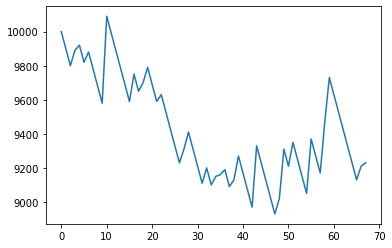

In [44]:
# 複勝
money = 10000
m = [10000]
a, b = 0, 0
atari = 0
for i in range(len(pre2)):
    if pre2.loc[i, "pred"] >= 0.70 and pre2.loc[i, "人気"] <= 10:
        a += 1
        if pre2.loc[i, "rank"] <= 3:
            d = returns.loc[(returns["0"] == "複勝") & (returns["id"] == str(pre2.loc[i, "id"]))]
            dn = list(list(d["1"])[0].split("br"))
            dp = list(list(d["2"])[0].split("br"))
            money += int(dp[pre2.loc[i, "rank"] - 1].replace(',', '')) - 100
            m.append(money)
            b += 1
            atari += int(dp[pre2.loc[i, "rank"] - 1].replace(',', ''))
        else:
            money -= 100
            m.append(money)
print(money)
print(b / a)
print(atari)
print(atari / a)
plt.plot(list(range(len(m))), m)
plt.show()

10010
37 14 0.3783783783783784
3710
100.27027027027027


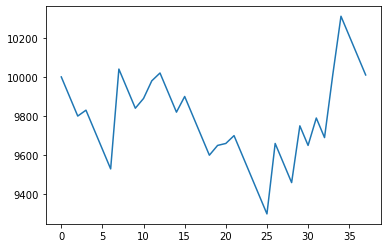

In [43]:
# 1 複勝
money = 10000
m = [10000]
a, b = 0, 0
atari = 0
for i in range(len(pre2)):
    if pre2.loc[i, "predrank"] == 1 and pre2.loc[i, "pred"] >= 0.7 and pre2.loc[i, "人気"] <= 10:
        a += 1
        if pre2.loc[i, "rank"] <= 3:
            d = returns.loc[(returns["0"] == "複勝") & (returns["id"] == str(pre2.loc[i, "id"]))]
            dn = list(list(d["1"])[0].split("br"))
            dp = list(list(d["2"])[0].split("br"))
            money += int(dp[pre2.loc[i, "rank"] - 1].replace(',', '')) - 100
            m.append(money)
            b += 1
            atari += int(dp[pre2.loc[i, "rank"] - 1].replace(',', ''))
        else:
            money -= 100
            m.append(money)
print(money)
print(a, b, b / a)
print(atari)
print(atari / a)
plt.plot(list(range(len(m))), m)
plt.show()

6510
0.02702702702702703
210
5.675675675675675


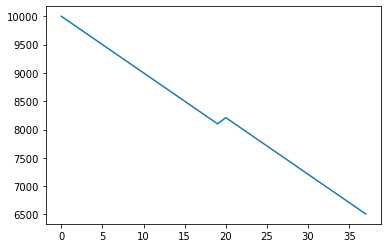

In [35]:
# 単勝
money = 10000
m = [10000]
a, b = 0, 0
atari = 0
for i in range(len(pre2)):
    if pre2.loc[i, "predrank"] == 1 and pre2.loc[i, "pred"] >= 0.7:
        a += 1
        if pre2.loc[i, "rank"] == 1:
            d = returns.loc[(returns["0"] == "単勝") & (returns["id"] == str(pre2.loc[i, "id"]))]
            dn = list(list(d["1"])[0].split("br"))
            dp = list(list(d["2"])[0].split("br"))
            money += int(dp[pre2.loc[i, "rank"] - 1].replace(',', '')) - 100
            m.append(money)
            b += 1
            atari += int(dp[pre2.loc[i, "rank"] - 1].replace(',', ''))
        else:
            money -= 100
            m.append(money)
print(money)
print(b / a)
print(atari)
print(atari / a)
plt.plot(list(range(len(m))), m)
plt.show()

In [36]:
# np.save('../Data/horse_id_dict.npy', horse_dict)
# np.save('../Data/jockey_id_dict.npy', jockey_dict)
horse_dict = np.load('../Data/horse_id_dict.npy', allow_pickle='TRUE').item()
jockey_dict = np.load('../Data/jockey_id_dict.npy', allow_pickle='TRUE').item()

In [37]:
df

,horse_id,date,枠番,性,齢,斤量,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5,pred_3
0,2018100570,2021-06-12,1,1,3,54.0,5,1200,0,1,0,2,2.7,1.0,11.0,17.102225,70.866227,0.598887,0.604976
1,2018104780,2021-06-12,1,2,3,56.0,5,1200,0,1,0,2,5.6,3.0,2.0,17.115887,70.557967,0.734697,0.725003
2,2018101518,2021-06-12,2,1,3,52.0,5,1200,0,1,0,2,372.5,15.0,16.0,16.992584,71.161468,0.187455,0.164405
3,2018101447,2021-06-12,2,2,3,56.0,5,1200,0,1,0,2,42.2,12.0,13.0,17.046042,70.871659,0.381422,0.378183
4,2018105258,2021-06-12,3,2,3,56.0,5,1200,0,1,0,2,3.8,2.0,2.0,17.115887,70.557967,0.740845,0.754487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47471,2015110065,2021-09-05,6,0,6,57.0,3,2600,2,1,0,2,27.5,6.0,7.0,15.991395,161.396077,0.491421,0.407982
47472,2017100368,2021-09-05,7,2,4,57.0,3,2600,2,1,0,2,13.1,5.0,6.0,16.014133,161.250721,0.624403,0.612082
47473,2018104097,2021-09-05,7,2,3,53.0,3,2600,2,1,0,2,47.7,9.0,9.0,15.965798,162.330606,0.413490,0.372950
47474,2017102850,2021-09-05,8,2,4,57.0,3,2600,2,1,0,2,5.1,3.0,4.0,16.013998,161.250721,0.725827,0.681590


In [38]:
# url = "https://yoso.netkeiba.com/?pid=race_yoso_list&race_id=202205021211&type="
# url2 ="https://race.netkeiba.com/race/shutuba.html?race_id=202205021211&rf=race_submenu"
# url = "https://yoso.netkeiba.com/?pid=race_yoso_list&race_id=202209030411&rf=yoso_top_pc"
# url2 = "https://race.netkeiba.com/race/shutuba.html?race_id=202209030411&rf=race_submenu"
# url = "https://yoso.netkeiba.com/?pid=race_yoso_list&race_id=202209040711&type="  # 菊花賞
# url2 = "https://race.netkeiba.com/race/shutuba.html?race_id=202209040711&rf=race_submenu" 
# url = "https://yoso.netkeiba.com/?pid=race_yoso_list&race_id=202209050411&type="  #エリザベス女王
# url2 = "https://race.netkeiba.com/race/shutuba.html?race_id=202209050411&rf=race_list"
url = "https://yoso.netkeiba.com/?pid=race_yoso_list&race_id=202209050611&type="  #マイルCS
url2 = "https://race.netkeiba.com/race/shutuba.html?race_id=202209050611&rf=race_submenu"
#メインとなるテーブルデータを取得
ddd = pd.read_html(url)[0].iloc[:8, :-1].iloc[:, :-1]
# ddd
um = list(pd.read_html(url2)[0].iloc[1:, 3])
waku = list(ddd.loc[0][::-1])
srs = list(ddd.loc[3][::-1])
ki = list(ddd.loc[4][::-1])
tt = list(ddd.loc[5][::-1])
on = list(ddd.loc[7][::-1])
sei, rei, seki = [], [], []
tyo, ozz, nin = [], [], []
kisyu, uma = [], []
for i in range(len(srs)):
    sei.append(srs[i][4])
    rei.append(int(srs[i][-1]))
    seki.append(int(srs[i][:2]))
    ozz.append(on[i][:int((len(on[i]) + 1) / 2)])
    nin.append(on[i][int((len(on[i]) + 1) / 2):-2])
    tyo.append(tt[i][2:])
    if ki[i] in jockey_dict:
        kisyu.append(jockey_dict[ki[i]])
    else:
        kisyu.append("0")
    if um[i] in horse_dict:
        uma.append(horse_dict[um[i]])
    else:
        uma.append("0")
um

['ウインカーネリアン',
 'ダノンザキッド',
 'シュネルマイスター',
 'サリオス',
 'ソダシ',
 'ジャスティンカフェ',
 'ロータスランド',
 'ピースオブエイト',
 'セリフォス',
 'ソウルラッシュ',
 'ホウオウアマゾン',
 'エアロロノア',
 'ベステンダンク',
 'ダノンスコーピオン',
 'ハッピーアワー',
 'ファルコニア']

In [39]:
race = pd.DataFrame(columns=df.columns).drop(["date", "pred_t", "pred_s", "pred_5", "pred_3"], axis=1)
import requests
from bs4 import BeautifulSoup
html = requests.get(url2)
html.encoding = "EUC-JP"
soup = BeautifulSoup(html.text, "html.parser")
cr = soup.find("div", attrs={"class": "RaceData01"}).find_all("span")[0].text
cr = soup.find("div", attrs={"class": "RaceData01"}).text.split(" ")[2:]

race["枠番"] = waku
# race["調教師"] = tyo
race["性"] = sei
race["齢"] = rei
race["斤量"] = seki
# race["単勝"] = ozz
# race["人気"] = nin
race["horse_id"] = uma
# race["jockey_id"] = kisyu
race["race_place"] = soup.find("div", attrs={"class": "RaceData02"}).find_all("span")[1].text
race["course_len"] = cr[0][1:-1]

race["race_type"] = cr[0][0]
race["race_type2"] = cr[1][1]
race["weather"] = cr[-2][3]
race["ground_state"] = cr[-1][3]

race['性'] = le_sei.transform(race['性'].values)
race['weather'] = le_we.transform(race['weather'].values)
race['race_type'] = le_ra.transform(race['race_type'].values)
race['race_type2'] = le_ra2.transform(race['race_type2'].values)
race['ground_state'] = le_gr.transform(race['ground_state'].values)
race['race_place'] = le_rp.transform(race['race_place'].values)

# race["単勝"] = race["単勝"].astype("float64")
# race["人気"] = race["人気"].astype("int64")
race["枠番"] = race["枠番"].astype("int64")
# race['fav'] = favorite(race)
# race['性'] = le_sei.fit_transform(race['性'].values)
# race['weather'] = le_we.fit_transform(race['weather'].values)
# race['race_type'] = le_ra.fit_transform(race['race_type'].values)
# race['race_type2'] = le_ra2.fit_transform(race['race_type2'].values)
# race['ground_state'] = le_gr.fit_transform(race['ground_state'].values)
# race['race_place'] = le_rp.fit_transform(race['race_place'].values)
# race['調教師'] = le_tyo.fit_transform(race['調教師'].values)
race['horse_id'] = race['horse_id'].astype("int64")
# race['jockey_id'] = race['jockey_id'].astype("int64")
race['course_len'] = race['course_len'].astype("int64")
ho = read_csv("horse_2022_G")
ho = ho.rename(columns={'Unnamed: 0': 'id'})
ho = ho.sort_values(["id", "日付"], ascending=[True, True]).reset_index(drop=True)
ho = ho.drop(['映像', 'ﾀｲﾑ指数', '厩舎ｺﾒﾝﾄ', '備考', "R", "通過", "ペース",
              "勝ち馬(2着馬)", "馬場指数", "レース名", "馬番", "賞金"], axis=1)
ho = ho.dropna(subset=['天気', "枠番", "オッズ", "人気", "タイム", "上り", "着差"]).reset_index(drop=True)
ho["日付"] = pd.to_datetime(ho['日付'], format='%Y/%m/%d')
l1, l2, l3, l4, l5 = [], [], [], [],[]
for i in range(len(race)):
    if (race.loc[i, "horse_id"] == ho["id"]).sum() != 0:
        l = list(ho[(race.loc[i, "horse_id"] == ho["id"])].iloc[-1, [6, 7, 8, 13, 11]])
    else:
        l = [0, 0, 0, "0:00.0", "00"]
    l1.append(l[0])
    l2.append(l[1])
    l3.append(int(l[2]))
#     l4.append(l[3])
#     l5.append(l[4][1:])

race["前オッズ"] = l1
race["前人気"] = l2
race["前着順"] = l3
# race["前距離"] = l5
# race["前タイム"] = change_time(l4)
# race["前距離"] = race["前距離"].astype("int64")
# race["前スピード"] = race["前距離"] / race["前タイム"]
race["pred_s"] = model_s.predict(race, num_iteration=model_s.best_iteration)
race["pred_t"] = model_t.predict(race, num_iteration=model_t.best_iteration)
race["pred_5"] = pd.DataFrame(model_5.predict(race, num_iteration=
                     model_5.best_iteration))
pred_race = model_3.predict(race, num_iteration=model_3.best_iteration)
race["pred_3"] = pd.DataFrame(pred_race)
race = race.fillna(0)
race

,horse_id,枠番,性,齢,斤量,race_place,course_len,weather,race_type,race_type2,ground_state,前オッズ,前人気,前着順,pred_s,pred_t,pred_5,pred_3
0,2017101429,1,2,5,57,8,1600,2,1,0,2,0.0,0.0,0,16.953939,94.326985,0.676056,0.684346
1,2018104963,2,2,4,57,8,1600,2,1,0,2,2.6,1.0,7,16.803878,95.038656,0.680743,0.669656
2,2018110007,2,2,4,57,8,1600,2,1,0,2,0.0,0.0,0,16.816149,94.937674,0.676121,0.683313
3,2017105327,3,2,5,57,8,1600,2,1,0,2,10.7,4.0,15,16.933065,94.400283,0.468731,0.421565
4,2018105233,3,1,4,55,8,1600,2,1,0,2,5.7,4.0,1,16.848841,94.445076,0.599893,0.591646
5,2018104576,4,2,4,57,8,1600,2,1,0,2,0.0,0.0,0,16.858393,94.442243,0.676121,0.684346
6,2017110144,4,1,5,55,8,1600,2,1,0,2,12.9,5.0,2,16.948195,94.390989,0.703759,0.679978
7,2019105318,5,2,3,56,8,1600,2,1,0,2,6.5,4.0,1,16.621359,96.280811,0.601083,0.591722
8,2019104462,5,2,3,56,8,1600,2,1,0,2,3.9,1.0,4,16.597678,96.320080,0.718301,0.681985
9,2018100382,6,2,4,57,8,1600,2,1,0,2,7.8,6.0,1,16.850893,94.466788,0.588749,0.571618


In [40]:
pre_race = []
for i in range(len(pred_race)):
    pre_race.append([i, um[i], ozz[i], nin[i], pred_race[i]])
pre_race = pd.DataFrame(pre_race, columns=['id', '馬名', 'オッズ', '人気', 'pred'])
pre_race = pre_race.sort_values([ "pred"], ascending=[False]).reset_index(drop=True)
pre_race["id"] = pre_race["id"].astype("int64")
# race.loc[list(np.argsort(list(pre_race["pred"]))[::-1])]
pre_race

,id,馬名,オッズ,人気,pred
0,10,ホウオウアマゾン,84.1,14,0.754487
1,0,ウインカーネリアン,26.0,9,0.684346
2,5,ジャスティンカフェ,18.9,7,0.684346
3,14,ハッピーアワー,435.6,16,0.684346
4,2,シュネルマイスター,3.6,1,0.683313
5,8,セリフォス,9.2,6,0.681985
6,6,ロータスランド,108.0,15,0.679978
7,1,ダノンザキッド,26.0,8,0.669656
8,15,ファルコニア,76.1,13,0.623690
9,7,ピースオブエイト,57.1,12,0.591722
